In [1]:
import pandas as pd
import numpy as np
import math
from collections import defaultdict
import ts_code.nsfg as nsfg
import ts_code.thinkstats2 as thinkstats2
import ts_code.thinkplot as thinkplot
import ts_code.first as first
import matplotlib.pyplot as plt
import ts_code.brfss as brfss
import statsmodels.formula.api as smf
%matplotlib inline

## Chapter 12 - Time series analysis

A **time series** is a sequence of measurements from a system that varies in time.

In [2]:
transactions = pd.read_csv('ts_code/mj-clean.csv', parse_dates=[5])

`parse_dates` tells `read_csv` to interpret values in column 5 as dates and convert them to *NumPy datetime64* objects.

In [3]:
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


Each transaction is an event in time, so we could treat this dataset as a time series. But the events are not equally spaced in time; the number of transactions reported each day varies from 0 to several hundred. 

Many methods used to analyze time series require the measurements to be equally
spaced, or at least things are simpler if they are.

In order to demonstrate these methods, I divide the dataset into groups by
reported quality, and then transform each group into an equally spaced series
by computing the mean daily price per gram.

In [4]:
def GroupByDay(transactions, func=np.mean):
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)
    
    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

In [5]:
quality = set(transactions.quality.values)
daily_data = GroupByDay(transactions)

In [6]:
dfs = {}
for qual in quality: 
    dfs[qual] = GroupByDay(transactions[transactions.quality==qual])

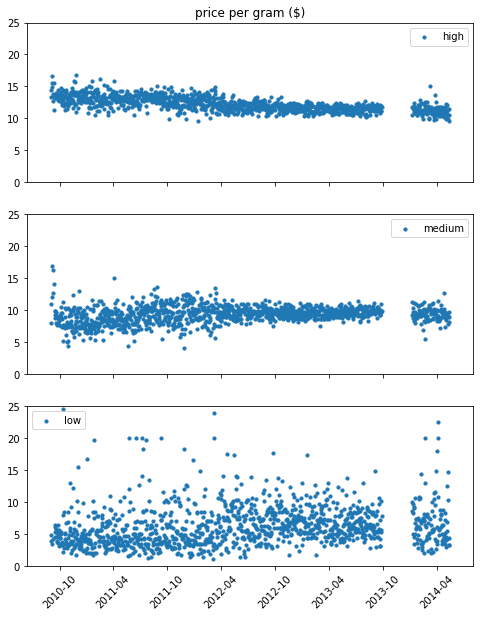

In [7]:
f, axes  = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8,10))
axs = {"high":0, "medium":1, 'low':2}
for name, daily in dfs.items():
    ax = axes[axs[name]]
    plt.xticks(rotation=45)
    title = 'price per gram ($)' if axs[name]==0 else ''
    ax.scatter(daily.index, daily.ppg, s=10, label=name)
    ax.set_title(title)
    ax.set_ylim(0,25)
    ax.legend()

Although there are methods specific to time series analysis, for many problems a simple way to get started is by applying general-purpose tools like linear regression.

In [8]:
def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data = daily)
    results = model.fit()
    return model, results

In [9]:
for name, daily in dfs.items():
    model, results = RunLinearModel(daily)
    print(name)
    print(results.summary())

high
                            OLS Regression Results                            
Dep. Variable:                    ppg   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     989.7
Date:                Sun, 04 Mar 2018   Prob (F-statistic):          3.69e-160
Time:                        14:28:56   Log-Likelihood:                -1510.1
No. Observations:                1241   AIC:                             3024.
Df Residuals:                    1239   BIC:                             3035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4496      0.045    296.080    

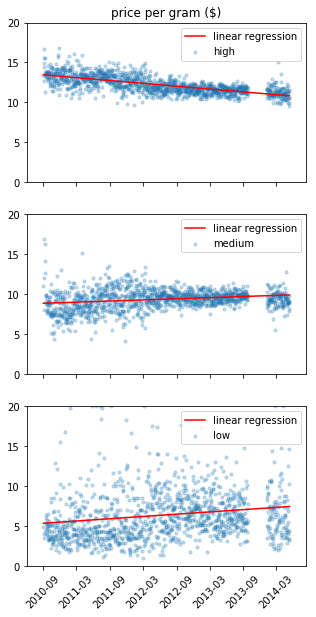

In [10]:
f, axes  = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,10))
axs = {"high":0, "medium":1, 'low':2}
for name, daily in dfs.items():
    ax = axes[axs[name]]
    title = 'price per gram ($)' if axs[name]==0 else ''
    plt.xticks(rotation=45)
    ax.scatter(daily.index, daily.ppg, alpha=0.25, s=10, label=name)
    ax.set_title(title)
    ax.set_ylim(0,20)
    _, results = RunLinearModel(daily)
    ax.plot(daily.index,results.fittedvalues, c='r', label='linear regression')
    ax.legend()

The model seems like a good linear fit for the data; nevertheless, linear regression is not the most appropriate choice for this data:

+ First, there is no reason to expect the long-term trend to be a line or any other simple function. In general, prices are determined by supply and demand, both of which vary over time in unpredictable ways.

+ Second, the linear regression model gives equal weight to all data, recent and past. For purposes of prediction, we should probably give more weight to recent data.

+ Finally, one of the assumptions of linear regression is that the residuals are uncorrelated noise. With time series data, this assumption is often false because successive values are correlated.

Most time series analysis is based on the modeling assumption that the observed series is the sum of three components:

+ **Trend:** A smooth function that captures persistent changes.

+ **Seasonality:** Periodic variation, possibly including daily, weekly, monthly, or yearly cycles.

+ **Noise:** Random variation around the long-term trend.

Regression is one way to extract the trend from a series.

If the trend is not a simple function, a good alternative is a **moving average**. 

A moving average divides the series into overlapping regions, called **windows**, and computes the average of the values in each window.

One of the simplest moving averages is the **rolling mean**, which computes the mean of the values in each window.

For example, if the window size is 3, the rolling mean computes the mean of values 0 through 2, 1 through 3, 2 through 4, etc.

In [11]:
series = pd.Series(np.arange(10))
series

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
dtype: int64

In [12]:
series.rolling(window=3, center=False).mean()

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    6.0
8    7.0
9    8.0
dtype: float64

The first two values are nan; the next value is the mean of the first three elements, 0, 1, and 2. The next value is the mean of 1, 2, and 3. And so on.

To apply a rolling mean to our cannabis data, we need to deal with the missing values. 

The index skips days with no data. For the analysis that follows, we need to represent this missing data explicitly. We can do that by \reindexing" the DataFrame:

In [13]:
dates = pd.date_range(daily_data.index.min(), daily_data.index.max())
reindexed = daily.reindex(dates)

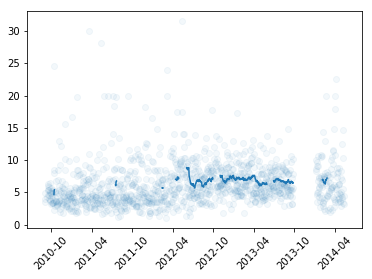

In [14]:
roll_mean = reindexed.ppg.rolling(window=30).mean()
plt.plot(roll_mean.index,roll_mean)
plt.xticks(rotation=45)
plt.scatter(reindexed.index, reindexed.ppg, alpha=0.05);

An alternative is the **exponentially-weighted moving average (EWMA)**, which has two advantages;

+ It computes a weighted average where the most recent value has the highest weight and the weights for previous values drop off exponentially.

+ The pandas implementation of EWMA handles missing values better.

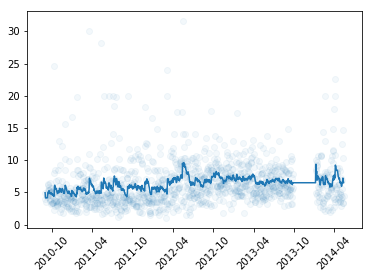

In [15]:
ewma = reindexed.ppg.ewm(span=30).mean()
plt.plot(ewma.index,ewma)
plt.xticks(rotation=45)
plt.scatter(reindexed.index, reindexed.ppg, alpha=0.05);

The **span** parameter corresponds roughly to the window size of a moving average; it controls how fast the weights drop off, so it determines the number of points that make a non-negligible contribution to each average.

Before testing for seasonality, we need to deal with missing data. One common way is to fill th emissing data with a moving average.

In [16]:
#reindexed.ppg.fillna(ewma, inplace=True)

Whereever there was a nan, it is filled with the corresponding value from the ewma.

The major drawback is it understates the noise. We solve that be adding in resamples residuals.

In [17]:
#create residuals, drop nan values from out vector
residuals = (reindexed.ppg - ewma).dropna()
#create fake data where we add resampled residuals as noise to our
#ewma values
fake_data = ewma + thinkstats2.Resample(residuals, len(reindexed))
#use the ewma with added noise to fill in missing data
reindexed.ppg.fillna(fake_data, inplace=True)

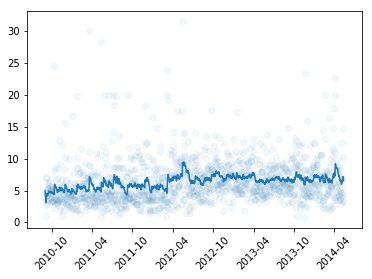

In [18]:
ewma = reindexed.ppg.ewm(span=30).mean()
plt.plot(ewma.index,ewma)
plt.xticks(rotation=45)
plt.scatter(reindexed.index, reindexed.ppg, alpha=0.05);
#check out that filled in data!

**Serial correlation** is when each value is correlated with the next value in the series. (ie: if the price is high on Monday we expect it to be high for a few more daya)

To compute serial correlation, we can shift the time series by an interval called a **lag**, and then compute the correlation of the shifted series with the original:

In [19]:
def SerialCorr(series, lag=1):
    #After the shift, the first lag values are nan
    #use a slice to remove them before computing Corr.
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [20]:
SerialCorr(reindexed.ppg)

0.10037912429433844

It makes more sense to if the correlation persists if you subracts away the trend. Compute the residual of the EWMA and then compute it's serial correlation.

In [21]:
ewma = reindexed.ppg.ewm(span=30).mean()
resid = reindexed.ppg - ewma
corr = SerialCorr(resid, 1)
corr

0.030358094264379902

If you think a series might have some serial correlation, but you don't know
which lags to test, you can test them all! The **autocorrelation function** is a function that maps from lag to the serial correlation with the given lag.

"Autocorrelation" is another name for serial correlation, used more often when the lag is not 1.

In [22]:
import statsmodels.tsa.stattools as smtsa
acf = smtsa.acf(resid, nlags=365, unbiased=True)

/home/scott/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [23]:
acf[365] #responds to lag of 365

0.050489420362694916

Time series analysis can be used to investigate, and sometimes explain, the
behavior of systems that vary in time. It can also make predictions.

In [24]:
def GenerateSimplePrediction(results, years):
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years)
    predict_df = pandas.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

There are three sources of error we should take into account:
    
+ **Sampling error:** The prediction is based on estimated parameters, which depend on random variation in the sample. If we run the experiment again, we expect the estimates to vary.

+ **Random variation:** Even if the estimated parameters are perfect, the observed data varies randomly around the long-term trend, and we expect this variation to continue in the future.

+ **Modeling error:** We have already seen evidence that the long-term trend is not linear, so predictions based on a linear model will eventually fail.

Bonus error; *unexpected future events*.

Use resampling to quantify sampling error. The goal is to use the actual observations to simulate what would happen if we ran it all over again. 

In [25]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [26]:
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

In [27]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel, axis=ax):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    ax.fill_between(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    ax.fill_between(years, low, high, alpha=0.3, color='gray')
    
    ax.plot()

### Exercises

**Exercise 12.1** The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change  linearly over time. 

We can add exibility to the model by adding a quadratic term.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions.

In [28]:
daily_data['years2'] = daily_data['years']**2 ##need to add to model function if I want to run based on quality

In [29]:
def RunQuadModel(daily):
    daily['years2'] = daily['years']**2
    model = smf.ols('ppg ~ years + years2', data = daily)
    results = model.fit()
    return model, results

In [30]:
#model, results = RunQuadModel(dfs['high'])

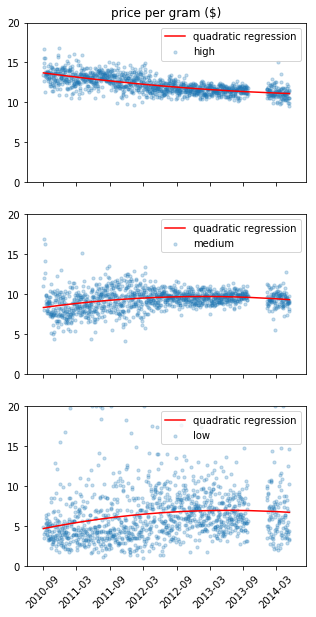

In [31]:
f, axes  = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,10))
axs = {"high":0, "medium":1, 'low':2}
for name, daily in dfs.items():
    ax = axes[axs[name]]
    title = 'price per gram ($)' if axs[name]==0 else ''
    plt.xticks(rotation=45)
    ax.scatter(daily.index, daily.ppg, alpha=0.25, s=10, label=name)
    ax.set_title(title)
    ax.set_ylim(0,20)
    _, results = RunQuadModel(daily)
    ax.plot(daily.index,results.fittedvalues, c='r', label='quadratic regression')
    ax.legend()

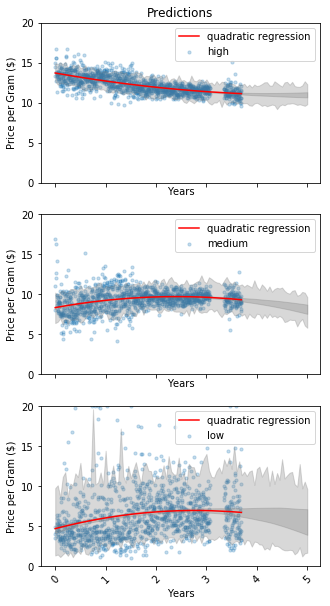

In [32]:
f, axes  = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,10))
axs = {"high":0, "medium":1, 'low':2}
years = np.linspace(0, 5, 101)

for name, daily in dfs.items():
    ax = axes[axs[name]]
    title = 'Predictions' if axs[name]==0 else ''
    plt.xticks(rotation=45)
    ax.scatter(daily.years, daily.ppg, alpha=0.25, s=10, label=name)
    ax.set_title(title)
    ax.set_ylim(0,20)
    ax.set_ylabel('Price per Gram ($)')
    ax.set_xlabel('Years')
    _, results = RunQuadModel(daily)
    PlotPredictions(daily, years, func=RunQuadModel)
    ax.plot(daily.years,results.fittedvalues, c='r', label='quadratic regression')
    ax.legend()

**Exercise 12.2** Write a definition for a class named *SerialCorrelationTest*
that extends *HypothesisTest* from Section 9.2. 

It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. 

Also test the residuals of the linear model and the quadratic model.

In [33]:
import ts_code.hypothesis as hyp

In [34]:
ser = dfs['high'].ppg

In [35]:
serialcorr = hyp.SerialCorrelationTest((ser, 1))

In [41]:
for name, daily in dfs.items():
    test = hyp.SerialCorrelationTest((daily.ppg,1))
    actual = test.actual
    pvalue = test.PValue()
    print('Quality: ', name, '\nActual Correlation: ', actual, '\np = ', pvalue)

Quality:  high 
Actual Correlation:  0.485229376195 
p =  0.0
Quality:  medium 
Actual Correlation:  0.160064299892 
p =  0.0
Quality:  low 
Actual Correlation:  0.116574974411 
p =  0.0


In [45]:
for name, daily in dfs.items():
    _, resultsL = RunLinearModel(daily)
    _, resultsQ = RunQuadModel(daily)

    resL = resultsL.resid
    resQ = resultsQ.resid
    
    testL = hyp.SerialCorrelationTest((resL,1))
    testQ = hyp.SerialCorrelationTest((resQ,1))

    actualL = testL.actual
    pvalueL = testL.PValue()
    actualQ = testQ.actual
    pvalueQ = testQ.PValue()
    print('Linear', '\nQuality: ', name, '\nActual Correlation: ', actualL, '\np = ', pvalueL)
    print('Quadratic', '\nQuality: ', name, '\nActual Correlation: ', actualQ, '\np = ', pvalueQ)

Linear 
Quality:  high 
Actual Correlation:  0.0757047376751 
p =  0.004
Quadratic 
Quality:  high 
Actual Correlation:  0.0560730816129 
p =  0.035
Linear 
Quality:  medium 
Actual Correlation:  0.11560586074 
p =  0.0
Quadratic 
Quality:  medium 
Actual Correlation:  0.0808952493892 
p =  0.006
Linear 
Quality:  low 
Actual Correlation:  0.0895083713478 
p =  0.003
Quadratic 
Quality:  low 
Actual Correlation:  0.0822265937058 
p =  0.005


**Exercise 12.3** There are several ways to extend the EWMA model to generate predictions. One of the simplest is something like this:

1. Compute the EWMA of the time series and use the last point as an intercept, inter.
2. Compute the EWMA of differences between successive elements in the time series and use the last point as a slope, slope.
3. To predict values at future times, compute $inter + slope \cdot dt$, where $d$t is the difference between the time of the prediction and the time of the last observation.

Use this method to generate predictions for a year after the last observation.

*Hints;*

+ Use `timeseries.FillMissing` to fill in missing values before running this analysis. That way the time between consecutive elements is consistent.

+ Use `Series.diff` to compute differences between successive elements.

+ Use `reindex` to extend the DataFrame index into the future.

+ Use `fillna` to put your *predicted* values into the DataFrame.

### Glossary

**time series:** A dataset where each value is associated with a timestamp, often a series of measurements and the times they were collected.

**window:** A sequence of consecutive values in a time series, often used to compute a moving average.

**moving average:** One of several statistics intended to estimate the underlying trend in a time series by computing averages (of some kind) for a series of overlapping windows.

**rolling mean:** A moving average based on the mean value in each window.

**exponentially-weighted moving average (EWMA):** A moving average based on a weighted mean that gives the highest weight to the most recent values, and exponentially decreasing weights to earlier values.

**span:** A parameter of EWMA that determines how quickly the weights decrease.

**serial correlation:** Correlation between a time series and a shifted or lagged version of itself.

**lag:** The size of the shift in a serial correlation or autocorrelation.

**autocorrelation:** A more general term for a serial correlation with any amount of lag.

**autocorrelation function:** A function that maps from lag to serial correlation.

**stationary:** A model is stationary if the parameters and the distribution of residuals does not change over time.